In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit_textbook.tools import vector2latex
from qiskit.visualization import plot_histogram # for plotting

**Implementing for 2 qubits |w⟩ = |11⟩**

In [2]:
grover_circuit = QuantumCircuit(int(input())) # preparing circuit for 2 qubit system

2


# Step1: initialize the state |s⟩

In [3]:
def initialize_s(qc, qubits):
    for q in qubits:
        qc.h(q) #Apply a H-gate to 'qubits' in qc
    
    return qc

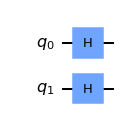

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

# Step2: apply the Oracle for 2 qubit system

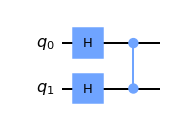

In [5]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

# Step3: apply diffuser

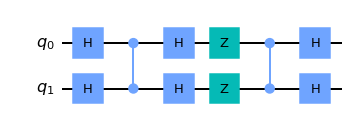

In [6]:
# create a general diffuser for any number of qubits

grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

Experiment with **simulator**

In [7]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
result = sv_sim.run(qobj).result()
statevec = result.get_statevector() # create state vector
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

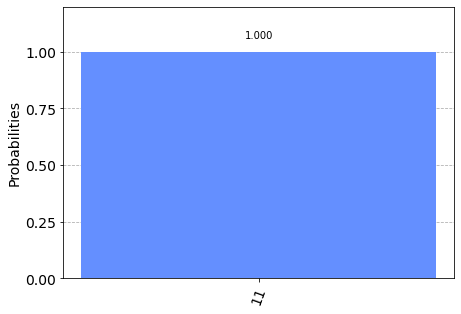

In [8]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_circuit)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

Amplitude of every state that is not |11⟩ is 0, this means we have a 100% chance of measuring |11⟩

Experiment with real **device**

In [9]:
provider = IBMQ.load_account()
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True)) # find the device

print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_athens


In [10]:
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
qobj = assemble(transpiled_grover_circuit)
job = device.run(qobj)
job_monitor(job, interval=2)

<ipython-input-10-d87337b3ad2f>:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = device.run(qobj)


Job Status: job has successfully run


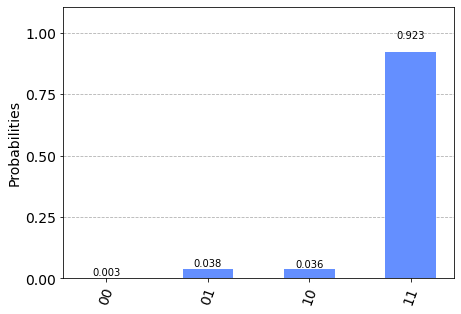

In [11]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

We confirm that in the majority of the cases the state |11⟩ is measured. The other results are due to errors in the quantum computation

**Implementing for 3 qubits** and searching for two marked states |101⟩ and |110⟩

# Create phase Oracle that will mark states |101⟩ and |110⟩ as the results

In [12]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [13]:
# diffuser for any number of qubits

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    return U_s

3
3


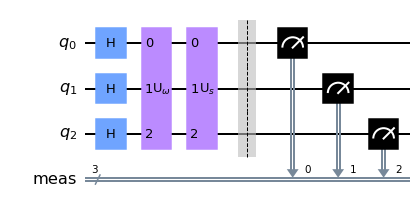

In [14]:
grover_circuit = QuantumCircuit(int(input()))
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(int(input())), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

Experiment with **simulators**

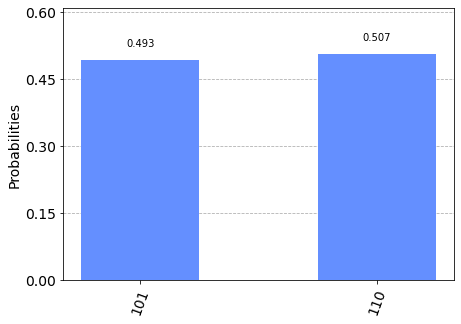

In [15]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
qobj = assemble(transpiled_grover_circuit)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Using this algorithm we have discovered the states |101⟩ and |110⟩

Experiment with **real devices**

In [16]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))

print("least busy backend: ", backend)

least busy backend:  ibmqx2


In [17]:
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
qobj = assemble(transpiled_grover_circuit)
job = device.run(qobj)
job_monitor(job, interval=2)

Job Status: job has successfully run


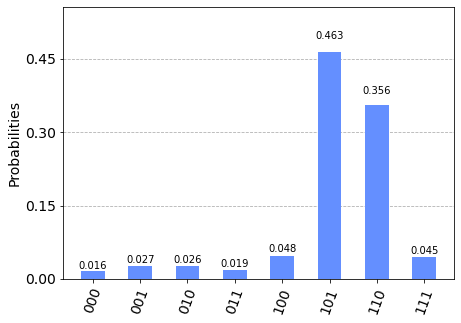

In [18]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

There is a higher chance of measuring |101⟩ and |110⟩. The other results are due to errors in the quantum computation